# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_202', 'block8_10_conv', 'conv_7b']
    LAST_LAYER = 'conv_7b'
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8064 - accuracy: 0.7302

947/947 [==============================] - 3505s 4s/step - loss: 0.8064 - accuracy: 0.7302 - val_loss: 1.7410 - val_accuracy: 0.5771
Epoch 2/200
947/947 [==============================] - 3250s 3s/step - loss: 0.6999 - accuracy: 0.7589 - val_loss: 2.8695 - val_accuracy: 0.6003
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7760

947/947 [==============================] - 3238s 3s/step - loss: 0.6498 - accuracy: 0.7760 - val_loss: 1.1805 - val_accuracy: 0.6687
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.7861

947/947 [==============================] - 3055s 3s/step - loss: 0.6122 - accuracy: 0.7861 - val_loss: 0.6168 - val_accuracy: 0.7811
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5987 - accuracy: 0.7914

947/947 [==============================] - 2740s 3s/step - loss: 0.5987 - accuracy: 0.7914 - val_loss: 0.5845 - val_accuracy: 0.7947
Epoch 6/200
947/947 [==============================] - 2477s 3s/step - loss: 0.5950 - accuracy: 0.7930 - val_loss: 0.6354 - val_accuracy: 0.7657
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5652 - accuracy: 0.8035

947/947 [==============================] - 2539s 3s/step - loss: 0.5652 - accuracy: 0.8035 - val_loss: 0.5404 - val_accuracy: 0.8052
Epoch 8/200
947/947 [==============================] - 2412s 3s/step - loss: 0.5377 - accuracy: 0.8106 - val_loss: 0.6110 - val_accuracy: 0.7825
Epoch 9/200
947/947 [==============================] - 2433s 3s/step - loss: 0.5192 - accuracy: 0.8190 - val_loss: 0.5638 - val_accuracy: 0.7970
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.8246

947/947 [==============================] - 2524s 3s/step - loss: 0.4951 - accuracy: 0.8246 - val_loss: 0.5365 - val_accuracy: 0.8102
Epoch 11/200
947/947 [==============================] - 2396s 3s/step - loss: 0.4882 - accuracy: 0.8271 - val_loss: 0.5882 - val_accuracy: 0.7999
Epoch 12/200
947/947 [==============================] - 2411s 3s/step - loss: 0.4743 - accuracy: 0.8326 - val_loss: 0.5414 - val_accuracy: 0.8066
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.8385

947/947 [==============================] - 2494s 3s/step - loss: 0.4524 - accuracy: 0.8385 - val_loss: 0.5151 - val_accuracy: 0.8204
Epoch 14/200
947/947 [==============================] - 2371s 3s/step - loss: 0.4401 - accuracy: 0.8431 - val_loss: 0.6064 - val_accuracy: 0.7926
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4325 - accuracy: 0.8463

947/947 [==============================] - 2485s 3s/step - loss: 0.4325 - accuracy: 0.8463 - val_loss: 0.5116 - val_accuracy: 0.8173
Epoch 16/200
947/947 [==============================] - 2389s 3s/step - loss: 0.4137 - accuracy: 0.8503 - val_loss: 0.6074 - val_accuracy: 0.7864
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 0.3960 - accuracy: 0.8567

947/947 [==============================] - 2499s 3s/step - loss: 0.3960 - accuracy: 0.8567 - val_loss: 0.5047 - val_accuracy: 0.8208
Epoch 18/200
947/947 [==============================] - 2365s 2s/step - loss: 0.3957 - accuracy: 0.8568 - val_loss: 0.5453 - val_accuracy: 0.8085
Epoch 19/200
947/947 [==============================] - ETA: 0s - loss: 0.3808 - accuracy: 0.8637

947/947 [==============================] - 2472s 3s/step - loss: 0.3808 - accuracy: 0.8637 - val_loss: 0.4706 - val_accuracy: 0.8320
Epoch 20/200
947/947 [==============================] - 2435s 3s/step - loss: 0.3596 - accuracy: 0.8694 - val_loss: 0.4757 - val_accuracy: 0.8287
Epoch 21/200
947/947 [==============================] - 2368s 3s/step - loss: 0.3507 - accuracy: 0.8704 - val_loss: 0.5047 - val_accuracy: 0.8253
Epoch 22/200
947/947 [==============================] - 2352s 2s/step - loss: 0.3338 - accuracy: 0.8783 - val_loss: 0.6076 - val_accuracy: 0.8053
Epoch 23/200
947/947 [==============================] - 2357s 2s/step - loss: 0.3279 - accuracy: 0.8802 - val_loss: 0.8695 - val_accuracy: 0.7834
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.8862

947/947 [==============================] - 2466s 3s/step - loss: 0.3101 - accuracy: 0.8862 - val_loss: 0.4536 - val_accuracy: 0.8362
Epoch 25/200
947/947 [==============================] - 2357s 2s/step - loss: 0.3032 - accuracy: 0.8903 - val_loss: 0.4810 - val_accuracy: 0.8319
Epoch 26/200
947/947 [==============================] - 2351s 2s/step - loss: 0.2881 - accuracy: 0.8930 - val_loss: 0.4564 - val_accuracy: 0.8415
Epoch 27/200
947/947 [==============================] - ETA: 0s - loss: 0.2835 - accuracy: 0.8954

947/947 [==============================] - 2462s 3s/step - loss: 0.2835 - accuracy: 0.8954 - val_loss: 0.4493 - val_accuracy: 0.8469
Epoch 28/200
947/947 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.9020

947/947 [==============================] - 2468s 3s/step - loss: 0.2700 - accuracy: 0.9020 - val_loss: 0.4449 - val_accuracy: 0.8477
Epoch 29/200
947/947 [==============================] - 2359s 2s/step - loss: 0.2542 - accuracy: 0.9059 - val_loss: 0.4535 - val_accuracy: 0.8490
Epoch 30/200
947/947 [==============================] - 2362s 2s/step - loss: 0.2464 - accuracy: 0.9101 - val_loss: 0.4683 - val_accuracy: 0.8412
Epoch 31/200
947/947 [==============================] - 2353s 2s/step - loss: 0.2407 - accuracy: 0.9095 - val_loss: 0.6049 - val_accuracy: 0.8058
Epoch 32/200
947/947 [==============================] - 2357s 2s/step - loss: 0.2327 - accuracy: 0.9140 - val_loss: 0.4571 - val_accuracy: 0.8519
Epoch 33/200
947/947 [==============================] - 2357s 2s/step - loss: 0.2309 - accuracy: 0.9152 - val_loss: 0.4590 - val_accuracy: 0.8486
Epoch 34/200
947/947 [==============================] - 2353s 2s/step - loss: 0.2182 - accuracy: 0.9205 - val_loss: 0.5554 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 256s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9758865316633952,
 'basal cell carcinoma': 0.9895013255357823,
 'dermatofibroma': 0.9731014275493169,
 'melanoma': 0.940588189648483,
 'nevus': 0.9708088647443335,
 'pigmented benign keratosis': 0.9880671446660857,
 'seborrheic keratosis': 0.9595087296002145,
 'solar lentigo': 0.9587603260169633,
 'squamous cell carcinoma': 0.9676869276804383,
 'vascular lesion': 0.9896335418589547}

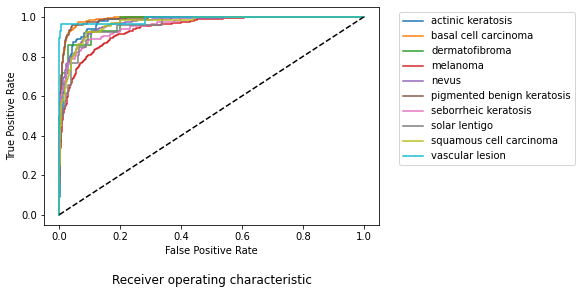

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

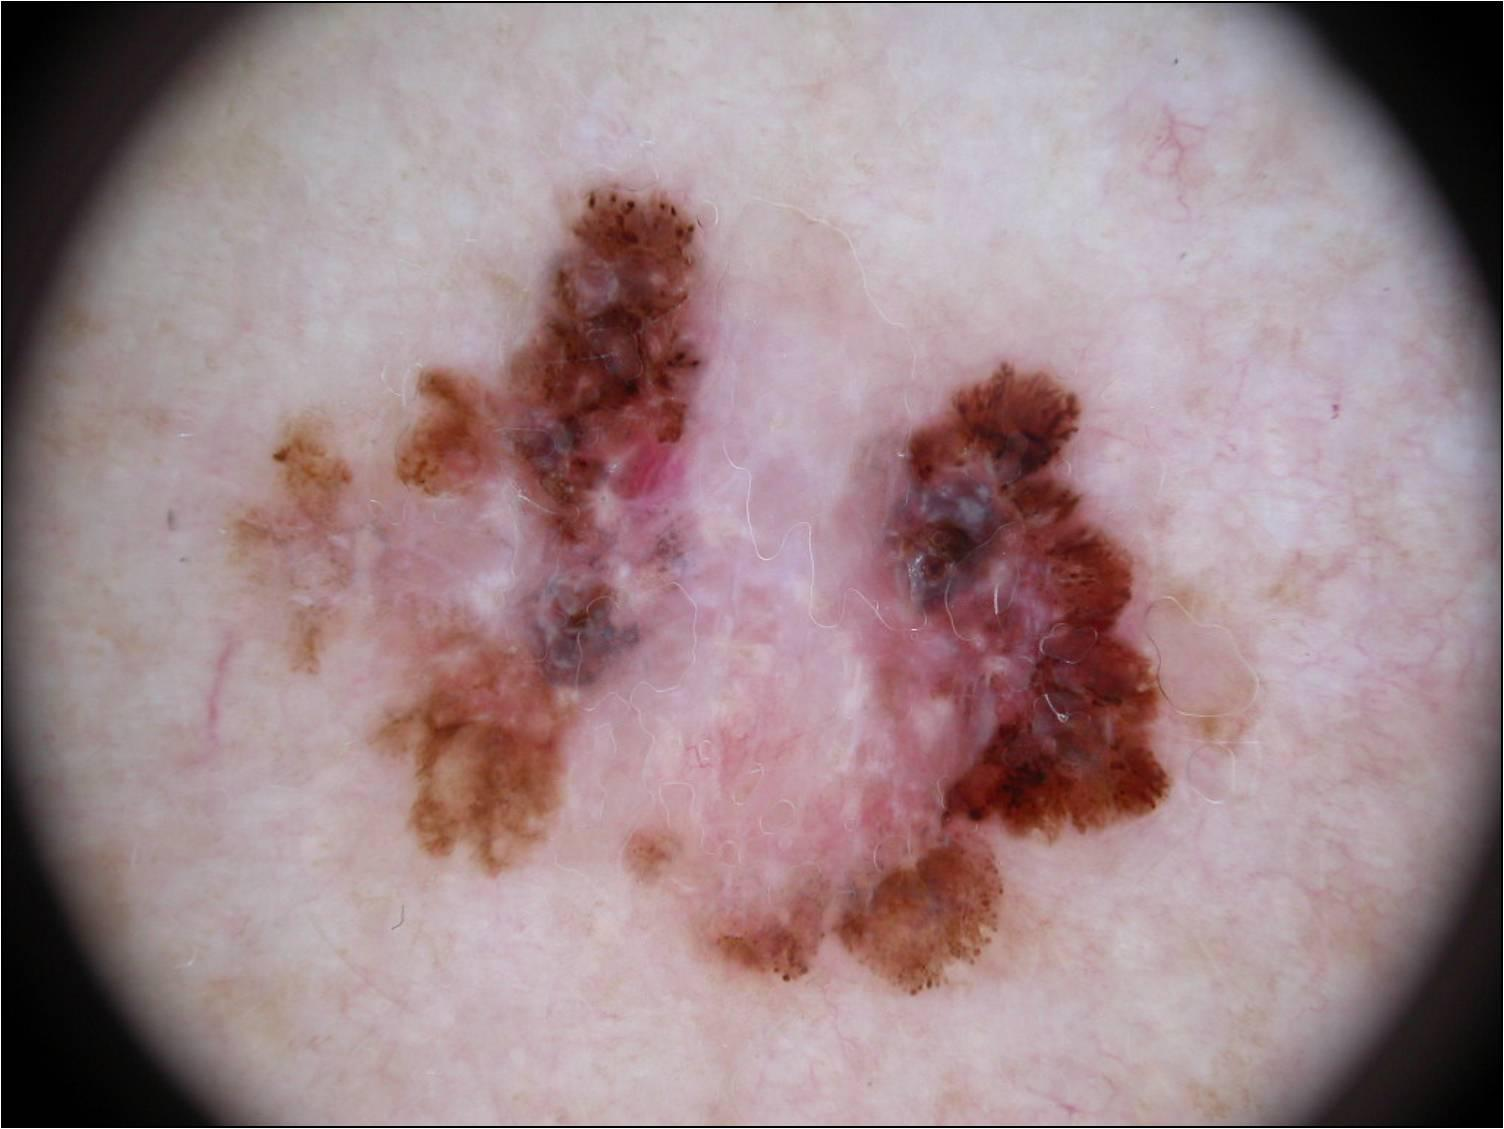

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

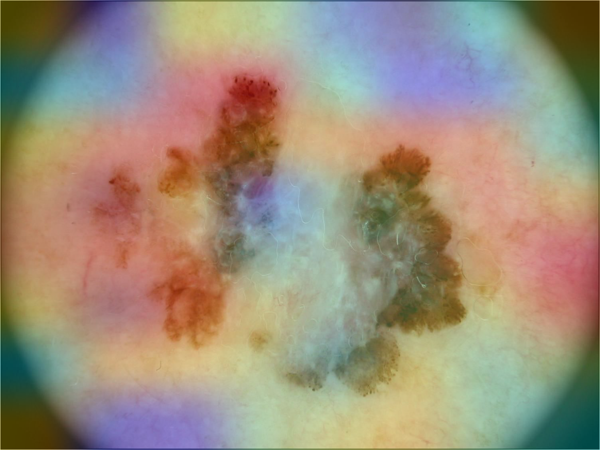

In [23]:
display_gradcam(melanoma_im_path, heatmap)